In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
import torch
from torchsummary import summary
torch.cuda.set_device(0)

In [2]:
path = untar_data(URLs.IMAGENETTE)

In [3]:
batch_size = 64
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, train = 'train', valid = 'val', bs = batch_size, size = 224, ds_tfms = tfms).normalize(imagenet_stats)

In [6]:
learn = cnn_learner(data, models.resnet34, metrics = accuracy)
learn = learn.load('unfreeze_imagenet_bs64')
# learn.summary()

class Flatten(nn.Module) :
    def forward(self, input):
        return input.view(input.size(0), -1)

def conv2(ni, nf) : 
    return conv_layer(ni, nf, stride = 2)

def conv_and_res(ni, nf): 
    return nn.Sequential(conv2(ni, nf), res_block(nf))
    
net = nn.Sequential(
    conv_and_res(3, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)
        
# net = CNN()
if torch.cuda.is_available() : 
    net = net.cuda()
    print('Model on GPU')

Model on GPU


In [7]:
# x, y = next(iter(data.train_dl))
# net(torch.autograd.Variable(x).cuda())
summary(net, (3, 224, 224))
# net

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             216
              ReLU-2          [-1, 8, 112, 112]               0
       BatchNorm2d-3          [-1, 8, 112, 112]              16
            Conv2d-4          [-1, 8, 112, 112]             576
              ReLU-5          [-1, 8, 112, 112]               0
       BatchNorm2d-6          [-1, 8, 112, 112]              16
            Conv2d-7          [-1, 8, 112, 112]             576
              ReLU-8          [-1, 8, 112, 112]               0
       BatchNorm2d-9          [-1, 8, 112, 112]              16
       MergeLayer-10          [-1, 8, 112, 112]               0
     SequentialEx-11          [-1, 8, 112, 112]               0
           Conv2d-12           [-1, 16, 56, 56]           1,152
             ReLU-13           [-1, 16, 56, 56]               0
      BatchNorm2d-14           [-1, 16,

In [6]:
class SaveFeatures :
    def __init__(self, m) : 
        self.handle = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, m, inp, outp) : 
        self.features = outp
    def remove(self) :
        self.handle.remove()
        
# saving outputs of all Basic Blocks
mdl = learn.model
sf = [SaveFeatures(m) for m in [mdl[0][2], mdl[0][4], mdl[0][5], mdl[0][6], mdl[0][7]]]
sf2 = [SaveFeatures(m) for m in [net[1], net[3], net[5], net[7], net[9]]]

In [7]:
# x, y = next(iter(data.train_dl))
# x = torch.autograd.Variable(x).cuda()
# out1 = mdl(x)
# out2 = net(x)
# for i in range(5) : 
#     assert(sf[i].features.shape == sf2[i].features.shape)
# del x, y

#### Training using teacher model

In [24]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)
num_epochs = 100
total_step = len(data.train_ds) // batch_size
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    net.train()
    for i, (images, labels) in enumerate(data.train_dl) :
        loss = 0.0
        if torch.cuda.is_available():
            images = torch.autograd.Variable(images).cuda().float()
            labels = torch.autograd.Variable(labels).cuda()
        else : 
            images = torch.autograd.Variable(images).float()
            labels = torch.autograd.Variable(labels)

        y_pred = net(images)
        y_pred2 = mdl(images)
        
        for k in range(5) : 
            loss += F.mse_loss(sf[k].features, sf2[k].features)
        
        loss += F.cross_entropy(y_pred, labels)
        trn.append(loss.item() / 6)

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(net.parameters(), 10)
        optimizer.step()

        if i % 200 == 199 :
            print('epoch = ', epoch, ' step = ', i + 1, ' of total steps ', total_step, ' loss = ', loss.item() / 6)
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(data.valid_dl) :
            if torch.cuda.is_available():
                images = torch.autograd.Variable(images).cuda().float()
                labels = torch.autograd.Variable(labels).cuda()
            else : 
                images = torch.autograd.Variable(images).float()
                labels = torch.autograd.Variable(labels)

            # Forward pass
            outputs = net(images)
            loss = F.cross_entropy(outputs, labels)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch + 1, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(net.state_dict(), '../saved_models/model0.pt')

epoch =  0  step =  200  of total steps  805  loss =  0.9172264734903971
epoch =  0  step =  400  of total steps  805  loss =  0.8226620356241862
epoch =  0  step =  600  of total steps  805  loss =  0.9226047197977701
epoch =  0  step =  800  of total steps  805  loss =  0.9060332775115967
epoch :  1  /  100  | TL :  0.9586156877671722  | VL :  1.1423591375350952
saving model
epoch =  1  step =  200  of total steps  805  loss =  0.8916026751200358
epoch =  1  step =  400  of total steps  805  loss =  0.859843889872233
epoch =  1  step =  600  of total steps  805  loss =  0.9872457186381022
epoch =  1  step =  800  of total steps  805  loss =  0.8324641386667887
epoch :  2  /  100  | TL :  0.8470254914854376  | VL :  1.206603765487671
epoch =  2  step =  200  of total steps  805  loss =  0.820203940073649
epoch =  2  step =  400  of total steps  805  loss =  0.7824554443359375
epoch =  2  step =  600  of total steps  805  loss =  0.772387425104777
epoch =  2  step =  800  of total step

KeyboardInterrupt: 

In [6]:
# learn = Learner(data, net, metrics = accuracy)
net.load_state_dict(torch.load('../saved_models/model5.pt'))

FileNotFoundError: [Errno 2] No such file or directory: '../saved_models/model5.pt'

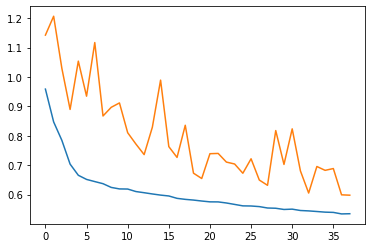

In [43]:
plt.plot(range(38), train_loss_list, range(38), val_loss_list)

In [7]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = torch.autograd.Variable(images).float()
        labels = torch.autograd.Variable(labels).float()
        
        if torch.cuda.is_available() : 
            images = images.cuda()
            labels = labels.cuda()

        outputs = Net.forward(images)
        outputs = F.log_softmax(outputs, dim = 1)

        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        labels = labels.data.cpu().numpy()
        pred_ind = pred_ind.data.cpu().numpy()
        
        # get difference
        diff_ind = labels - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

_get_accuracy(data.valid_dl, net)

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 10.92 GiB total capacity; 3.14 GiB already allocated; 8.50 MiB free; 198.26 MiB cached)

In [7]:
net = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    Flatten(),
    nn.Linear(512 * 7 * 7, 512),
    nn.Linear(512, 10)
)
net = net.cuda()

#### Training without teacher model

In [6]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

num_epochs = 100
total_step = len(data.train_ds) // batch_size
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    net.train()
    for i, (images, labels) in enumerate(data.train_dl) :
        if torch.cuda.is_available():
            images = torch.autograd.Variable(images).cuda().float()
            labels = torch.autograd.Variable(labels).cuda()
        else : 
            images = torch.autograd.Variable(images).float()
            labels = torch.autograd.Variable(labels)

        y_pred = net(images)
        
        loss = F.cross_entropy(y_pred, labels)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(net.parameters(), 10)
        optimizer.step()

        if i % 50 == 49 :
            print('epoch = ', epoch, ' step = ', i + 1, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(data.valid_dl) :
            if torch.cuda.is_available():
                images = torch.autograd.Variable(images).cuda().float()
                labels = torch.autograd.Variable(labels).cuda()
            else : 
                images = torch.autograd.Variable(images).float()
                labels = torch.autograd.Variable(labels)

            # Forward pass
            outputs = net(images)
            loss = F.cross_entropy(outputs, labels)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    val_acc = _get_accuracy(data.valid_dl, net)
    print('epoch : ', epoch + 1, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss, ' | VA : ', val_acc * 100)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(net.state_dict(), '../saved_models/model1_normal.pt')

epoch =  0  step =  50  of total steps  201  loss =  1.755843997001648


KeyboardInterrupt: 

In [9]:
net.load_state_dict(torch.load('../saved_models/model4_normal.pt'))
_get_accuracy(data.valid_dl, net)

0.862

#### Evaluation

In [9]:
def _evaluate(folder_name, net) :
    acc_list = list()
    for i in range(5) : 
        filename = '../saved_models/' + folder_name + '/model' + str(i) + '.pt'
        net.load_state_dict(torch.load(filename))
        acc_list.append(_get_accuracy(data.valid_dl, net))

    acc_list = [i * 100 for i in acc_list]
    print(acc_list)
    print(np.mean(acc_list))
    print(np.std(acc_list))

In [ ]:
_evaluate('normal', net)